## Uses Files : vrbo_formatted_labels.csv and vrbo_formatted.csv

In [22]:
import os
import pandas as pd
import plotly.express as px
from transformers import pipeline
import re
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yuto1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
cu_path = os.getcwd()

## Sentiment Analysis (Twitter-roBERTa-base transformers)

In this section, we perform the sentiment analyis. To perform this, I used "Twitter-roBERTa-base" transformers to label the review text into whther it is  negative or positive or neutral.

In [24]:
file = cu_path + "/vrbo_formatted.csv"
df = pd.read_csv(file , encoding = "utf-8")

In [25]:
print(len(df))

2503


In [26]:
fig = px.histogram(df, x="star_rating")
fig.show()

From this visualization, we can see that most of the rating is over 4, but there are properties whose rating is below 4 to some extent.

I transformed the review text. Since all of the text was combined with '|||' for each properties, I made the list of the text so that we can use them to transformers model.

In [27]:
for index , i in zip(df.index , df["reviews_text"]):
    if pd.isna(i) == False:
        i = i.split("|||")
    else:
        i = []
    df.at[index ,"reviews_text"] = i

We only select the properties whose have the reviews comments and star rating.Since it's only 743 properties hold this condition, we will use almost 30%(743/2503) of the whose dataset.

In [28]:
df = df[(df["star_rating"].isna() == False) & (len(df["reviews_text"]) != 0)]

In [29]:
for index , text_list in zip(df.index , df["reviews_text"]):
    reviews_text_list = []
    for i in text_list:
        i = re.sub(r"\\n" , "" , i)
        reviews_text_list.append(i)
    df.at[index,"reviews_text"] = reviews_text_list

Load the pretained transformers model, and label for each review text. after labelling, we save this data frame as "vrbo_formatted_with_labels.csv"

In [30]:
pipe_model = pipeline("text-classification" , model='cardiffnlp/twitter-roberta-base-sentiment')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [31]:
count = 0
df["reviews_label"] = ""
for index , i in zip(df.index , df["reviews_text"]):
    print(index)
    label_list = []
    for r in i:
        try:
            temp_dict = {}
            results = pipe_model(r)
            for each in results:
                temp_dict[each["label"]] = each["score"]
            r = dict(sorted(temp_dict.items(), key=lambda item: item[1] , reverse = True))
            label = str(list(r.keys())[0])
            label_list.append(label)
        except:
            label_list.append("")
            count = count + 1
    df.at[index , "reviews_label"] = label_list

0
1
2
3
4
7
8
9
10
12
13
17
18
19
21
22
23
24
27
30
35
40
42
44
141
142
143
144
145
147
148
149
151
152
153
155
156
159
160
161
162
164
165
166
167
170
172
173
175
177
178
179
180
181
183
184
186
193
195
204
290
291
292
293
294
296
297
298
299
300
301
302
304
305
306
307
308
309
311
315
318
320
322
328
333
336
337
384
385
387
388
389
390
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
408
410
412
413
414
415
418
420
421
424
425
427
431
432
433
434
435
436
437
439
440
444
445
446
447
448
449
451
452
453
458
461
464
465
467
468
469
470
471
476
477
478
479
480
482
483
484
485
486
489
491
493
495
497
499
500
501
502
503
504
506
508
509
518
519
520
521
522
525
526
527
528
529
530
531
532
533
534
536
540
541
542
543
548
551
553
555
560
562
567
569
570
613
614
615
616
618
620
621
624
625
626
627
632
633
634
636
637
640
641
642
643
644
646
647
648
649
652
653
654
655
656
657
658
660
661
662
664
665
668
669
670
671
677
678
682
683
686
690
691
692
693
694
695
697
698
699
701
703
704


In [32]:
df.to_csv(cu_path + "/vrbo_formatted_with_labels.csv" , index = False)

Since it takes times to perform the transformes, from second time, I will use the csv file that we saved above.

In [33]:
df = pd.read_csv(cu_path + "/vrbo_formatted_with_labels.csv" , encoding = 'utf-8')

In [34]:
for index , each_list in zip(df.index , df["reviews_label"]):
    new_list = []
    each_list = each_list.replace("[" , "").replace("]" , "")
    each_list = list(each_list.split(","))
    for i in each_list:
        i = i.replace("'"  ,"").replace(" " , "")
        new_list.append(i)
    df.at[index , "reviews_label"] = new_list

#### I have created two groups. One is the group with the highest rating and the other is the group with the lowest rating. The definition of a highly rated group is when star_rating is higher than 3, and the definition of a low rated group is when star_rating is 3 or less.

In [36]:
df_low = df[df["star_rating"] <= 3]
df_high = df[df["star_rating"] > 3]

In [37]:
df_low_label = df_low["reviews_label"].tolist()
df_low_label_list = []
for each in df_low_label:
    for i in each:
        df_low_label_list.append(i) 

        
df_high_label = df_high["reviews_label"].tolist()
df_high_label_list = []
for each in df_high_label:
    for i in each:
        df_high_label_list.append(i) 


low_label = ["Lower rating"] * len(df_low_label_list)
high_label = ["Higher rating"] * len(df_high_label_list)

low_label.extend(high_label)
df_low_label_list.extend(df_high_label_list)

label_df = pd.DataFrame(list(zip(low_label,df_low_label_list)) , columns = ["rating_group" , "reaction"])

name_dict = {"LABEL_0" : "Negative" , "LABEL_1" : "Neutral" , "LABEL_2" : "Positive"}
label_df["reaction"] = label_df["reaction"].replace(name_dict)

In [38]:
label_df = label_df.groupby(["rating_group","reaction"]).size()
label_df = label_df.reset_index()
label_df = label_df.rename(columns = {0 : "count"})

In [39]:
fig = px.bar(label_df, x="rating_group", y="count", color="reaction", title="Wide-Form Input")
fig.show()

In [48]:
label_df_low = label_df[label_df["rating_group"] == "Lower rating"]
fig = px.bar(label_df_low, x="reaction", y="count", title="Review Proportion in Lower Rating properties")
fig.update_layout(font_size=12, hoverlabel_font_size=12)
fig.show()

In [68]:
label_df_high = label_df[label_df["rating_group"] == "Higher rating"]
fig = px.bar(label_df_high, x="reaction", y="count", title="Review Proportion in Higher Rating properties")
fig.show()

## Identify what topic are important in these negative comment (LDA)

Within lower rating, select only the negative comment

Omit the unnecessary characters

In [42]:
lower_negative_comment_list = []
df_low_review = df_low[["reviews_text" , "reviews_label"]]
for text_list , label_list in zip(df_low_review["reviews_text"] , df_low_review["reviews_label"]):
    text_list = list(text_list.split("', '"))
    for text , label in zip(text_list , label_list):
        text = text.replace("['" , "").replace("']" , "")
        text = re.sub('[,\.!?]', '', text)
        text = text.lower()
        if label == "LABEL_0":
            lower_negative_comment_list.append(text)

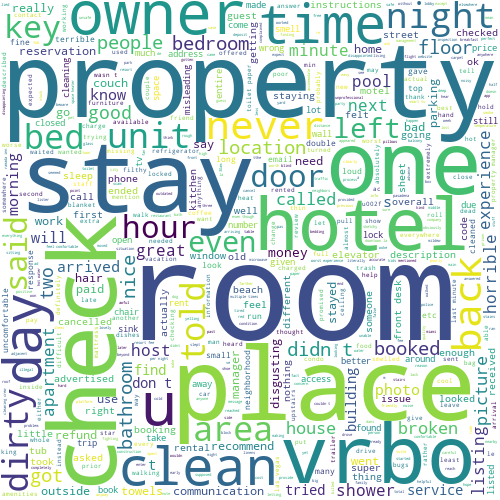

In [61]:
long_string = ','.join(lower_negative_comment_list)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',width=500, height=500)
wordcloud.generate(long_string)
wordcloud.to_image()

We deleted the stopwords. We added the stopwords based on the wordcloud above.

In [55]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','one' ,
                   'u' , 'told' , 'didn t', 'would',
                  'overall','well' , 'could', 'next'])

In [63]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data_words = list(sent_to_words(lower_negative_comment_list))
# print(data_words)
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['never', 'stay', 'anywhere', 'company', 'owns', 'start', 'drove', 'hours', 'get', 'took', 'mins', 'find', 'get', 'never', 'given', 'instructions', 'enter', 'woke', 'morning', 'charged', 'refundable', 'deposit', 'times', 'morning', 'woken', 'someone', 'working', 'us', 'garage', 'rented']


In [57]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 3), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [65]:
result_list = []
for each_list in data_words:
    for each in each_list:
        result_list.append(each)

This is the wordcloud of the data which is used in LDA model

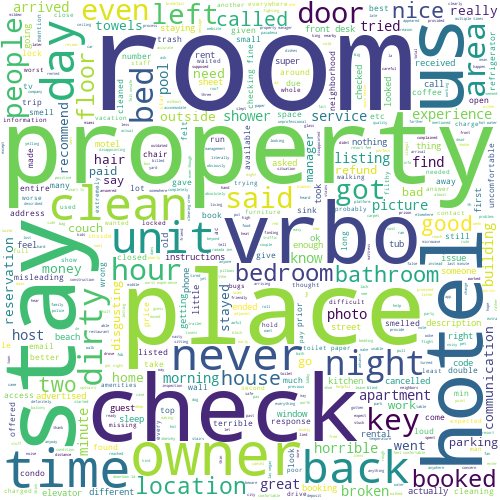

In [67]:
long_string = ','.join(result_list)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',width=500, height=500)
wordcloud.generate(long_string)
wordcloud.to_image()

In [58]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.012*"room" + 0.009*"property" + 0.008*"us" + 0.007*"back" + 0.007*"get" + '
  '0.007*"hotel" + 0.007*"check" + 0.007*"dirty" + 0.007*"outside" + '
  '0.006*"pictures"'),
 (1,
  '0.008*"vrbo" + 0.008*"stay" + 0.008*"check" + 0.007*"morning" + '
  '0.006*"place" + 0.006*"us" + 0.006*"owner" + 0.006*"property" + '
  '0.006*"room" + 0.006*"like"'),
 (2,
  '0.015*"stay" + 0.011*"hotel" + 0.008*"also" + 0.007*"check" + 0.007*"floor" '
  '+ 0.006*"dirty" + 0.006*"room" + 0.006*"broken" + 0.006*"rooms" + '
  '0.006*"like"'),
 (3,
  '0.010*"house" + 0.009*"property" + 0.007*"day" + 0.006*"vrbo" + '
  '0.006*"stay" + 0.006*"back" + 0.006*"apartment" + 0.005*"like" + '
  '0.005*"check" + 0.005*"owner"'),
 (4,
  '0.014*"stay" + 0.013*"place" + 0.011*"vrbo" + 0.010*"room" + 0.009*"owner" '
  '+ 0.007*"book" + 0.007*"horrible" + 0.006*"booked" + 0.006*"days" + '
  '0.005*"hotel"'),
 (5,
  '0.012*"room" + 0.009*"place" + 0.008*"get" + 0.007*"two" + 0.007*"never" + '
  '0.006*"dirty" + 0.005